In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import haversine_distances

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [4]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [5]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'categories']
    vec_columns = ['name', 'categories', 'address', 
                  'state']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [6]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [7]:
%load_ext Cython

In [8]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [9]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [10]:
def add_features(df):

    latlon_values = data.loc[df['id'], ['latitude', 'longitude']].values
    matlatlon_values = data.loc[df['match_id'], ['latitude', 'longitude']].values
    distances = []
    for latlon, matlatlon in zip(latlon_values, matlatlon_values):
        distances.append(haversine_distances([latlon, matlatlon])[0, 1])
    df['distance'] = distances
    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        vc = data[col].value_counts()
        geshs = []
        levens = []
        jaros = []
        lcss = []
        vc1 = []
        vc2 = []

        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan':
                vc1.append(vc[s])
            else:
                vc1.append(np.nan)

            if match_s != 'nan':
                vc2.append(vc[match_s])
            else:
                vc2.append(np.nan)

            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        df[f'{col}_CE_1'] = vc1
        df[f'{col}_CE_2'] = vc2
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
    return df

In [11]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [12]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [13]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [14]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [15]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [16]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data[col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 13916774
Pos rate: 0.07237136997410464
                       id          match_id     kdist  kneighbors  \
9669022  E_fb2423f3ecb535  E_ef0bc5de79e10b  0.002962        16.0   
4179479  E_5711e77f4f6716  E_88601b987e6f2c  0.013405         7.0   
2843346  E_fe5b07e0a8a9c5  E_0cffaaebc584d9  0.006918         4.0   
5672212  E_f624aa54796b00  E_b227f88db2fe18  0.003901         9.0   
1412325  E_7b07bee29838a7  E_8d81634e3378a0  0.001450         2.0   

        point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
9669022  P_7aeff722d67fa9       0.001594                 8.0    0.858537   
4179479  P_728ab357db351e       0.013241                 7.0    0.012328   
2843346  P_5f256e9da11ffe       0.004618                 6.0    0.498116   
5672212  P_1ef23c0ca7dfdf       0.002758                 7.0    0.414395   
1412325  P_4507ac6a9d85a4       0.000710                 2.0    1.043830   

         kneighbors_mean  label  
9

In [17]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226548761979743


In [18]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,92.76%,7.24%
validation set - fold 0,92.76%,7.24%
development set - fold 1,92.76%,7.24%
validation set - fold 1,92.76%,7.24%
development set - fold 2,92.76%,7.24%
validation set - fold 2,92.76%,7.24%
development set - fold 3,92.76%,7.24%
validation set - fold 3,92.76%,7.24%
development set - fold 4,92.76%,7.24%


# model learning

In [19]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/6 [00:00<?, ?it/s]

In [20]:
features = ['distance', 'kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

for c in CFG.feat_columns:
    features += [c + "_CE_1", c + "_CE_2"]

print(len(features))
print(features)

67
['distance', 'kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categories_nlcs', 'categories_sim', 'name_CE_1', 'name_CE_2', 'address_CE_1', 'address_CE_2', 'city_CE_1', 'city_CE_2', 'state_CE_1', 'state_CE_2', 'zip_CE_1', 'zip_CE_2', 'categories_

In [21]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0423716
[100]	valid_0's binary_logloss: 0.0398549
[150]	valid_0's binary_logloss: 0.0387309
[200]	valid_0's binary_logloss: 0.0379883
[250]	valid_0's binary_logloss: 0.0373648
[300]	valid_0's binary_logloss: 0.0369168
[350]	valid_0's binary_logloss: 0.036531
[400]	valid_0's binary_logloss: 0.0361269
[450]	valid_0's binary_logloss: 0.035904
[500]	valid_0's binary_logloss: 0.0356476
[550]	valid_0's binary_logloss: 0.0354077
[600]	valid_0's binary_logloss: 0.0352016
[650]	valid_0's binary_logloss: 0.0349913
[700]	valid_0's binary_logloss: 0.0348007
[750]	valid_0's binary_logloss: 0.0346049
[800]	valid_0's binary_logloss: 0.0344222
[850]	valid_0's binary_logloss: 0.0342462
[900]	valid_0's binary_logloss: 0.0340591
[950]	valid_0's binary_logloss: 0.033934
[1000]	valid_0's binary_logloss: 0.0337815
[1050]	valid_0's binary_logloss: 0.0336341
[1100]	valid_0's binary_logloss: 0.0334985
[1150]	valid_0's binary_logloss: 0.0333796
[1200]	valid_0's binary_logloss: 0

In [ ]:
del train_data
gc.collect()

85

#Check Feature Importances

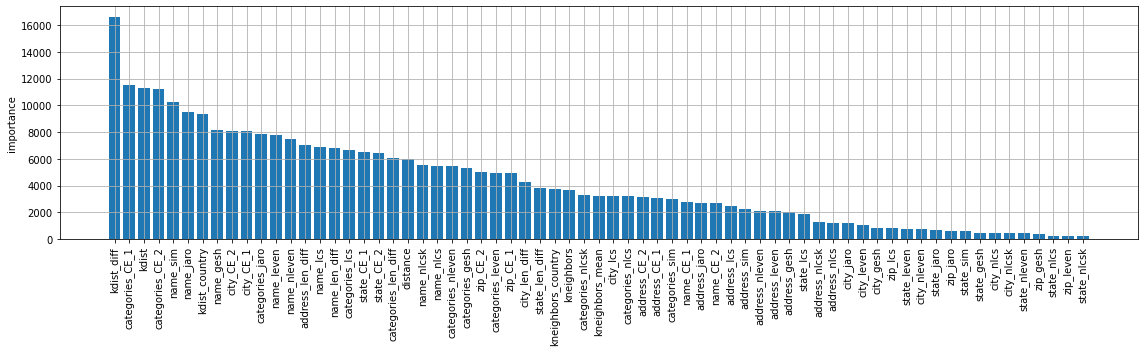

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-27 19:12:44,868] A new study created in memory with name: no-name-5b9331f5-db33-45ff-807b-75068789ee43
[I 2022-05-27 19:13:39,259] Trial 0 finished with value: 0.829150413273323 and parameters: {'threshold': 0.8521277207366811}. Best is trial 0 with value: 0.829150413273323.


CV: 0.829150


[I 2022-05-27 19:13:59,325] Trial 1 finished with value: 0.8403222864328213 and parameters: {'threshold': 0.4340419613080546}. Best is trial 1 with value: 0.8403222864328213.


CV: 0.840322


[I 2022-05-27 19:14:21,000] Trial 2 finished with value: 0.8155546633993717 and parameters: {'threshold': 0.16820599696503413}. Best is trial 1 with value: 0.8403222864328213.


CV: 0.815555


[I 2022-05-27 19:14:40,667] Trial 3 finished with value: 0.8424260064472523 and parameters: {'threshold': 0.5381672153467835}. Best is trial 3 with value: 0.8424260064472523.


CV: 0.842426


[I 2022-05-27 19:15:02,131] Trial 4 finished with value: 0.8102903798726075 and parameters: {'threshold': 0.14483549953850705}. Best is trial 3 with value: 0.8424260064472523.


CV: 0.810290


[I 2022-05-27 19:15:21,296] Trial 5 finished with value: 0.8305514431304667 and parameters: {'threshold': 0.8408144068569445}. Best is trial 3 with value: 0.8424260064472523.


CV: 0.830551


[I 2022-05-27 19:15:41,800] Trial 6 finished with value: 0.8424662869515804 and parameters: {'threshold': 0.5736131676313799}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.842466


[I 2022-05-27 19:16:02,134] Trial 7 finished with value: 0.84189207293294 and parameters: {'threshold': 0.6307588622404837}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.841892


[I 2022-05-27 19:16:23,843] Trial 8 finished with value: 0.8025443048811121 and parameters: {'threshold': 0.11820819647926428}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.802544


[I 2022-05-27 19:16:45,129] Trial 9 finished with value: 0.8286418283674479 and parameters: {'threshold': 0.2535794683922242}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.828642


[I 2022-05-27 19:17:03,106] Trial 10 finished with value: 0.7226006314645191 and parameters: {'threshold': 0.9975230023384004}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.722601


[I 2022-05-27 19:17:23,708] Trial 11 finished with value: 0.8424218691212079 and parameters: {'threshold': 0.5406743562334836}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.842422


[I 2022-05-27 19:17:43,486] Trial 12 finished with value: 0.8390858839942456 and parameters: {'threshold': 0.40106451585819103}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.839086


[I 2022-05-27 19:18:03,945] Trial 13 finished with value: 0.8416160685124715 and parameters: {'threshold': 0.6436246103025077}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.841616


[I 2022-05-27 19:18:24,277] Trial 14 finished with value: 0.837849006325011 and parameters: {'threshold': 0.750629723287012}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.837849


[I 2022-05-27 19:18:44,425] Trial 15 finished with value: 0.8349748011958636 and parameters: {'threshold': 0.32810417250940116}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.834975


[I 2022-05-27 19:19:05,006] Trial 16 finished with value: 0.8424494345237922 and parameters: {'threshold': 0.5506914985610945}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.842449


[I 2022-05-27 19:19:25,448] Trial 17 finished with value: 0.8408509792580977 and parameters: {'threshold': 0.6770198592862368}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.840851


[I 2022-05-27 19:19:45,114] Trial 18 finished with value: 0.8416632981479639 and parameters: {'threshold': 0.48067134339873857}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.841663


[I 2022-05-27 19:20:06,282] Trial 19 finished with value: 0.8322758239391947 and parameters: {'threshold': 0.2907961516115034}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.832276


[I 2022-05-27 19:20:25,652] Trial 20 finished with value: 0.837187636359661 and parameters: {'threshold': 0.7617881781656894}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.837188


[I 2022-05-27 19:20:46,184] Trial 21 finished with value: 0.8424343779775951 and parameters: {'threshold': 0.5562759263747917}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.842434


[I 2022-05-27 19:21:06,713] Trial 22 finished with value: 0.842341026026241 and parameters: {'threshold': 0.6021397273308731}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.842341


[I 2022-05-27 19:21:30,625] Trial 23 finished with value: 0.6765970049867552 and parameters: {'threshold': 0.013357889984079774}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.676597


[I 2022-05-27 19:21:51,290] Trial 24 finished with value: 0.8390646130219351 and parameters: {'threshold': 0.40010776976165957}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.839065


[I 2022-05-27 19:22:12,003] Trial 25 finished with value: 0.8418701646121999 and parameters: {'threshold': 0.48993378858142345}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.841870


[I 2022-05-27 19:22:31,321] Trial 26 finished with value: 0.8390491906488353 and parameters: {'threshold': 0.7249145331735131}. Best is trial 6 with value: 0.8424662869515804.


CV: 0.839049


[I 2022-05-27 19:22:51,744] Trial 27 finished with value: 0.8425098955479189 and parameters: {'threshold': 0.567531528504462}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842510


[I 2022-05-27 19:23:12,635] Trial 28 finished with value: 0.8374435839401442 and parameters: {'threshold': 0.3687408210621941}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.837444


[I 2022-05-27 19:23:46,100] Trial 29 finished with value: 0.8173980830223755 and parameters: {'threshold': 0.914574972916427}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.817398


[I 2022-05-27 19:24:06,303] Trial 30 finished with value: 0.8307596699529939 and parameters: {'threshold': 0.8392439105291736}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.830760


[I 2022-05-27 19:24:25,874] Trial 31 finished with value: 0.8424760662895923 and parameters: {'threshold': 0.5647757110162474}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842476


[I 2022-05-27 19:24:50,555] Trial 32 finished with value: 0.8413728138685681 and parameters: {'threshold': 0.4671761171371839}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.841373


[I 2022-05-27 19:25:11,375] Trial 33 finished with value: 0.8424565992693411 and parameters: {'threshold': 0.5787400107090781}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842457


[I 2022-05-27 19:25:33,570] Trial 34 finished with value: 0.839836915017552 and parameters: {'threshold': 0.707008380720108}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.839837


[I 2022-05-27 19:25:54,424] Trial 35 finished with value: 0.8424479658346964 and parameters: {'threshold': 0.5764827732872394}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842448


[I 2022-05-27 19:26:13,962] Trial 36 finished with value: 0.8415755617811806 and parameters: {'threshold': 0.6490164314349358}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.841576


[I 2022-05-27 19:26:34,520] Trial 37 finished with value: 0.8404921377260548 and parameters: {'threshold': 0.43961688673135946}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.840492


[I 2022-05-27 19:26:55,095] Trial 38 finished with value: 0.8422075619824847 and parameters: {'threshold': 0.5152891969353249}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842208


[I 2022-05-27 19:27:15,631] Trial 39 finished with value: 0.8424219847924794 and parameters: {'threshold': 0.5894622074748261}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842422


[I 2022-05-27 19:27:34,805] Trial 40 finished with value: 0.836328723934522 and parameters: {'threshold': 0.7740128471517856}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.836329


[I 2022-05-27 19:27:55,120] Trial 41 finished with value: 0.8423024488512373 and parameters: {'threshold': 0.6086179141211858}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842302


[I 2022-05-27 19:28:15,806] Trial 42 finished with value: 0.8424214207390789 and parameters: {'threshold': 0.5480136796356752}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842421


[I 2022-05-27 19:28:35,506] Trial 43 finished with value: 0.84225994572938 and parameters: {'threshold': 0.5169880633990845}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842260


[I 2022-05-27 19:28:56,806] Trial 44 finished with value: 0.8403346587084894 and parameters: {'threshold': 0.6924371927130413}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.840335


[I 2022-05-27 19:29:17,495] Trial 45 finished with value: 0.8401045444441031 and parameters: {'threshold': 0.42860669073275603}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.840105


[I 2022-05-27 19:29:37,930] Trial 46 finished with value: 0.8413570962096111 and parameters: {'threshold': 0.6586474795547228}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.841357


[I 2022-05-27 19:29:57,445] Trial 47 finished with value: 0.8422099748859739 and parameters: {'threshold': 0.6184942008207659}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842210


[I 2022-05-27 19:30:18,356] Trial 48 finished with value: 0.8411088415450471 and parameters: {'threshold': 0.45620940292806555}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.841109


[I 2022-05-27 19:30:38,398] Trial 49 finished with value: 0.8358897746488148 and parameters: {'threshold': 0.3417417010073672}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.835890


[I 2022-05-27 19:30:58,404] Trial 50 finished with value: 0.8345135886323052 and parameters: {'threshold': 0.8009887616602027}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.834514


[I 2022-05-27 19:31:18,863] Trial 51 finished with value: 0.8424834115037837 and parameters: {'threshold': 0.5710799670524429}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842483


[I 2022-05-27 19:31:39,354] Trial 52 finished with value: 0.8424927785326519 and parameters: {'threshold': 0.5667447320506827}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842493


[I 2022-05-27 19:31:58,971] Trial 53 finished with value: 0.8422391274938231 and parameters: {'threshold': 0.5220434694578798}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842239


[I 2022-05-27 19:32:19,535] Trial 54 finished with value: 0.8416227928276349 and parameters: {'threshold': 0.6443367398626874}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.841623


[I 2022-05-27 19:32:39,054] Trial 55 finished with value: 0.8424520691549423 and parameters: {'threshold': 0.5827352132553587}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842452


[I 2022-05-27 19:33:01,362] Trial 56 finished with value: 0.824509564030612 and parameters: {'threshold': 0.2202531323383219}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.824510


[I 2022-05-27 19:33:21,929] Trial 57 finished with value: 0.8419797330487038 and parameters: {'threshold': 0.5010471634029537}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.841980


[I 2022-05-27 19:33:41,430] Trial 58 finished with value: 0.8424570747975572 and parameters: {'threshold': 0.5632725317670043}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842457


[I 2022-05-27 19:34:02,173] Trial 59 finished with value: 0.839507477850233 and parameters: {'threshold': 0.4116384798152657}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.839507


[I 2022-05-27 19:34:22,629] Trial 60 finished with value: 0.8404390181083757 and parameters: {'threshold': 0.6881203806208195}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.840439


[I 2022-05-27 19:34:42,304] Trial 61 finished with value: 0.8424849349085797 and parameters: {'threshold': 0.5682649374796823}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842485


[I 2022-05-27 19:35:02,791] Trial 62 finished with value: 0.8424312038702264 and parameters: {'threshold': 0.5555612700717545}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842431


[I 2022-05-27 19:35:23,138] Trial 63 finished with value: 0.8421277781341183 and parameters: {'threshold': 0.6209314750421023}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842128


[I 2022-05-27 19:35:43,705] Trial 64 finished with value: 0.8416907533055371 and parameters: {'threshold': 0.4817856915451483}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.841691


[I 2022-05-27 19:36:03,123] Trial 65 finished with value: 0.8390668887461613 and parameters: {'threshold': 0.724080449335648}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.839067


[I 2022-05-27 19:36:23,748] Trial 66 finished with value: 0.8424217641760001 and parameters: {'threshold': 0.542874766601513}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842422


[I 2022-05-27 19:36:44,027] Trial 67 finished with value: 0.8411472117507927 and parameters: {'threshold': 0.6653223311176539}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.841147


[I 2022-05-27 19:37:05,243] Trial 68 finished with value: 0.842487571695811 and parameters: {'threshold': 0.572154683286125}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842488


[I 2022-05-27 19:37:24,635] Trial 69 finished with value: 0.8421025188871024 and parameters: {'threshold': 0.6225117369658439}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842103


[I 2022-05-27 19:37:45,146] Trial 70 finished with value: 0.8413747791358664 and parameters: {'threshold': 0.4679029246199154}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.841375


[I 2022-05-27 19:38:05,867] Trial 71 finished with value: 0.8424929764500808 and parameters: {'threshold': 0.5708567985513701}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842493


[I 2022-05-27 19:38:25,540] Trial 72 finished with value: 0.8424399964246861 and parameters: {'threshold': 0.593739175704153}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842440


[I 2022-05-27 19:38:46,180] Trial 73 finished with value: 0.8422403576097411 and parameters: {'threshold': 0.5216233674225035}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842240


[I 2022-05-27 19:39:05,836] Trial 74 finished with value: 0.8419285824776004 and parameters: {'threshold': 0.4954765344540569}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.841929


[I 2022-05-27 19:39:26,326] Trial 75 finished with value: 0.8424849084742166 and parameters: {'threshold': 0.5710562027478636}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842485


[I 2022-05-27 19:39:46,696] Trial 76 finished with value: 0.842405812503512 and parameters: {'threshold': 0.5969367060583208}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842406


[I 2022-05-27 19:40:07,433] Trial 77 finished with value: 0.8424333312479343 and parameters: {'threshold': 0.5422507141096173}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842433


[I 2022-05-27 19:40:28,053] Trial 78 finished with value: 0.8417256064551146 and parameters: {'threshold': 0.6377962179662314}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.841726


[I 2022-05-27 19:40:47,873] Trial 79 finished with value: 0.8408994574909447 and parameters: {'threshold': 0.4504719519004293}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.840899


[I 2022-05-27 19:41:09,029] Trial 80 finished with value: 0.8424825000878317 and parameters: {'threshold': 0.5732615543125426}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842483


[I 2022-05-27 19:41:28,562] Trial 81 finished with value: 0.8424863922930946 and parameters: {'threshold': 0.5684772162204772}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842486


[I 2022-05-27 19:41:48,896] Trial 82 finished with value: 0.8424699990377099 and parameters: {'threshold': 0.5752179452928767}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842470


[I 2022-05-27 19:42:09,572] Trial 83 finished with value: 0.8422056122627795 and parameters: {'threshold': 0.5152468990178348}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842206


[I 2022-05-27 19:42:30,078] Trial 84 finished with value: 0.8411200674311228 and parameters: {'threshold': 0.6666858360051047}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.841120


[I 2022-05-27 19:42:49,630] Trial 85 finished with value: 0.8423393968275683 and parameters: {'threshold': 0.6004430437713828}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842339


[I 2022-05-27 19:43:10,216] Trial 86 finished with value: 0.8424269271387581 and parameters: {'threshold': 0.5354645924722914}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842427


[I 2022-05-27 19:43:29,597] Trial 87 finished with value: 0.8397004058317176 and parameters: {'threshold': 0.7101321883569018}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.839700


[I 2022-05-27 19:43:49,904] Trial 88 finished with value: 0.8416900441709821 and parameters: {'threshold': 0.6402102467734854}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.841690


[I 2022-05-27 19:44:10,698] Trial 89 finished with value: 0.8418770980157013 and parameters: {'threshold': 0.4915894346182855}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.841877


[I 2022-05-27 19:44:30,370] Trial 90 finished with value: 0.8425000637441172 and parameters: {'threshold': 0.5667032355268853}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842500


[I 2022-05-27 19:44:50,851] Trial 91 finished with value: 0.8424965073747311 and parameters: {'threshold': 0.5670147750268282}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842497


[I 2022-05-27 19:45:10,234] Trial 92 finished with value: 0.8419706754291031 and parameters: {'threshold': 0.6274314168560995}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.841971


[I 2022-05-27 19:45:30,513] Trial 93 finished with value: 0.8423351720387959 and parameters: {'threshold': 0.6065313353858759}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842335


[I 2022-05-27 19:45:50,834] Trial 94 finished with value: 0.8424723273257392 and parameters: {'threshold': 0.5591363617218607}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842472


[I 2022-05-27 19:46:11,586] Trial 95 finished with value: 0.8423507841763305 and parameters: {'threshold': 0.5272208360152952}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842351


[I 2022-05-27 19:46:31,225] Trial 96 finished with value: 0.8420000535103735 and parameters: {'threshold': 0.501582886392171}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842000


[I 2022-05-27 19:46:51,573] Trial 97 finished with value: 0.8424388420858463 and parameters: {'threshold': 0.5854198983930305}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.842439


[I 2022-05-27 19:47:12,211] Trial 98 finished with value: 0.8398592735427899 and parameters: {'threshold': 0.42177042411377447}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.839859


[I 2022-05-27 19:47:31,496] Trial 99 finished with value: 0.8406639818136317 and parameters: {'threshold': 0.682529066256131}. Best is trial 27 with value: 0.8425098955479189.


CV: 0.840664


In [ ]:
threshold = study.best_params['threshold']
threshold

0.567531528504462

In [ ]:
study.best_value

0.8425098955479189

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.842510


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,distance,name_sim,name_gesh,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,127201.000000,127201.000000,123185.000000,123185.000000,118114.000000,131147.000000,131147.0,131147.000000,131147.000000,131147.000000,...,97053.000000,97053.000000,97053.000000,110947.000000,111131.000000,131147.000000,97053.000000,97053.000000,97053.000000,1.311470e+05
mean,0.006604,6.332961,0.003595,6.373698,0.423507,6.638444,1.0,0.005576,0.264070,0.407804,...,12.556521,0.674404,9.118533,5609.737622,5610.329908,9.176619,0.536945,0.581260,0.582408,1.897574e-01
std,0.051445,5.257837,0.024503,5.274827,2.340016,5.323535,0.0,0.041538,0.296467,0.247351,...,11.690195,0.243956,7.380557,6769.093706,6768.340396,11.088261,0.353677,0.330388,0.330088,1.778061e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.951605e-12
25%,0.000459,2.000000,0.000344,2.000000,0.005744,2.000000,1.0,0.000361,0.000000,0.210526,...,0.000000,0.483287,4.000000,761.000000,757.000000,0.000000,0.000000,0.285714,0.285714,2.587684e-02
50%,0.001152,5.000000,0.000888,5.000000,0.057328,5.000000,1.0,0.000950,0.173203,0.391304,...,12.000000,0.583333,7.000000,2892.000000,2892.000000,6.000000,0.714286,0.483871,0.487179,1.330258e-01
75%,0.003118,10.000000,0.002403,10.000000,0.318294,10.500000,1.0,0.002637,0.489220,0.583333,...,17.000000,1.000000,12.000000,7208.000000,7208.000000,13.000000,0.823529,1.000000,1.000000,3.346567e-01
max,4.310371,19.000000,2.388985,19.000000,170.784270,19.000000,1.0,2.388985,1.000000,1.000000,...,87.000000,1.000000,77.000000,25481.000000,25481.000000,90.000000,1.000000,1.000000,1.000000,5.675288e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
2316448,E_1163ef0a18a3f0,E_6252bfa76647eb,0.001301,4.0,P_4cd0932074cc05,0.000931,3.0,0.396943,3.5,1,...,NaN,NaN,NaN,NaN,21438.0,15,NaN,NaN,NaN,0.382431
1626649,E_db2438bf6449f0,E_84fc4d68bd3169,0.000106,2.0,P_908ef3a8074a67,0.000078,2.0,0.361775,2.0,1,...,NaN,NaN,NaN,NaN,9423.0,8,NaN,NaN,NaN,0.066457
5996765,E_87e1885a3a7284,E_f3f8568b398813,0.001356,10.0,NaN,NaN,NaN,NaN,10.0,1,...,22.0,0.520924,11.0,4.0,2671.0,22,0.666667,1.000000,0.333333,0.011410
837344,E_78578596717ac0,E_a7aec92eff3d2a,0.000000,1.0,P_d0d581fca223bd,0.000000,0.0,NaN,0.5,1,...,20.0,0.386957,4.0,1565.0,1697.0,8,0.869565,0.266667,0.173913,0.510516
3039347,E_5659caa7681796,E_f0d8a15eeceb22,0.001638,5.0,P_dc8a2e7305cd83,0.001469,5.0,0.115403,5.0,1,...,9.0,0.509259,3.0,5108.0,11981.0,3,0.750000,0.333333,0.250000,0.368241
7219576,E_ad92486684665a,E_aec23619508f34,0.001134,12.0,P_07de7d5a866580,0.001134,12.0,0.000150,12.0,1,...,0.0,1.000000,9.0,9676.0,9676.0,0,0.000000,1.000000,1.000000,0.207084
5916723,E_63feef1fabaedd,E_9bf6c5ee32f19a,0.001471,10.0,P_7e9ac07989be98,0.001470,11.0,0.000512,10.5,1,...,0.0,1.000000,15.0,976.0,976.0,0,0.000000,1.000000,1.000000,0.161195
4957730,E_b4a468de475e31,E_3cd2d3ca4263ff,0.003345,8.0,P_122328bf9b4770,0.003093,8.0,0.081681,8.0,1,...,0.0,1.000000,19.0,4894.0,4894.0,0,0.000000,1.000000,1.000000,0.169916
1401099,E_75bd5063f4652f,E_c3840039132eaf,0.000625,2.0,P_3694199a98fe4a,0.000364,10.0,0.714360,6.0,1,...,NaN,NaN,NaN,1658.0,NaN,29,NaN,NaN,NaN,0.197190
1861320,E_44b52cedf434a7,E_f599376f3e8720,0.000465,3.0,P_50750bff7f3c6a,0.000191,1.0,1.433543,2.0,1,...,0.0,1.000000,5.0,21494.0,21494.0,0,0.000000,1.000000,1.000000,0.412537


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
278690,E_3e8ff275400c86,Procurement Cubicles,-6.241340,106.829832,Trans TV - Lt 3A Jl Kapt Tendean 12-14A,Jakarta,Jakarta Capital Region,NaN,ID,NaN,NaN,Offices,P_745299120115a1,4,1.0
530530,E_7738b1c22e1c37,TransTV,-6.241297,106.829730,#2imano3ll4ng • Trans Corp - Jln. Kapten Pierr...,Mampang Prapatan,Jakarta,12790,ID,NaN,NaN,TV Stations,P_745299120115a1,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
364037,E_51cc5a34c16986,Nascaterra,-14.828009,-74.936327,NaN,NaN,NaN,NaN,PE,NaN,NaN,Bars,P_b70e2ceaad7d5c,1,1.0
1019487,E_e50a5414ac70ff,Nazka Terra,-14.828019,-74.939227,NaN,NaN,NaN,NaN,PE,NaN,NaN,Bars,P_b70e2ceaad7d5c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
95622,E_15717079a7e5e3,Jaz Aquaviva Makadi Bay,26.98267,33.874029,Makadi Bay,Hurghada,Egypte,NaN,EG,https://jazhotels.com/hurghada/madinat-makadi/...,+20653590225,Resorts,P_05b76a8d0b0558,4,1.0
701127,E_9d775b2f90f43c,room 3328,26.98287,33.874832,NaN,NaN,Rode Zee,NaN,EG,NaN,NaN,Hotels,P_05b76a8d0b0558,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
399143,E_59afc503ebcd48,Movapark,37.234492,40.634922,NaN,NaN,Mardin,47400,TR,NaN,NaN,Shopping Malls,P_5d3a10f5b358e8,4,1.0
636075,E_8f019a73bcdb16,Movapark Salon,37.243221,40.645672,NaN,NaN,NaN,NaN,TR,NaN,NaN,General Entertainment,P_5d3a10f5b358e8,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
548706,E_7b50c919984642,مستشفى الاموات,29.137321,48.096509,NaN,NaN,NaN,NaN,KW,NaN,NaN,Hospitals,P_c1787409157b85,4,1.0
844850,E_bdbc0614641e26,مستشفى العدان حوادث,29.135096,48.096637,NaN,NaN,Al Ahmadi,NaN,KW,NaN,NaN,Hospitals,P_c1787409157b85,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
701699,E_9d99314f1638e4,Министерство иностранных дел (МИД РФ),55.746596,37.583409,"Смоленская-Сенная пл., 32/34",Москва,Москва,119200,RU,http://www.mid.ru,4992441606,Government Buildings,P_c7897ce34239ce,4,1.0
769228,E_acc706fd34829d,МИД Отдел Франции,55.746136,37.585561,NaN,NaN,NaN,NaN,RU,NaN,NaN,Racetracks,P_c7897ce34239ce,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
76135,E_110d5e15a04702,Bishan 156 St 13,1.344375,103.856638,NaN,NaN,NaN,NaN,SG,NaN,NaN,Residential Buildings (Apartments / Condos),P_5eb34f708a8d43,1,1.0
668945,E_9645ddae3c5552,Blk 156 Bishan Street 13,1.345594,103.856614,156 Bishan St 13,Singapore,Singapore,570156,SG,NaN,NaN,Residential Buildings (Apartments / Condos),P_5eb34f708a8d43,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
732056,E_a470cdaefcc004,明治屋 浜松遠鉄百貨店,34.704380,137.733308,中区砂山町320-2,浜松市,静岡県,430-8588,JP,NaN,+81534575451,Grocery Stores,P_c164177185adb8,1,1.0
952768,E_d606413b68c3b6,明治屋 浜松ストアー,34.706348,137.732842,NaN,浜松市,静岡県,430-8588,JP,NaN,NaN,Grocery Stores,P_c164177185adb8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
21472,E_04d37344e3b493,Школа-лицей № 3 им. А. С. Макаренко,44.962837,34.113319,"ул. Лермонтова, 14А",Симферополь,Крым,95034,UA,NaN,NaN,"Schools, High Schools, Middle Schools",P_65769c7e8a4d68,4,1.0
81891,E_125160d22f1d40,последняя парта у стенки,44.963206,34.113815,NaN,NaN,NaN,NaN,UA,NaN,NaN,NaN,P_65769c7e8a4d68,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
16854,E_03d0375d5d449b,Little River Road House,33.665621,-82.336832,6622 Washington Rd,Appling,GA,NaN,US,NaN,7063099067,Pizza Places,P_d89437d5f1169c,4,1.0
383926,E_56429518173b6a,The Funny Farm,33.626084,-82.282603,Washington Rd.,Appling,GA,NaN,US,NaN,NaN,NaN,P_d89437d5f1169c,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
185884,E_29b4836e1c0b17,Global Securities GCS - Bogota,4.654901,-74.056407,NaN,NaN,NaN,NaN,CO,NaN,NaN,Offices,P_3d389df02c0691,1,1.0
790412,E_b187d95cad6dbc,Global Securities S. A.,4.654376,-74.055764,Cra 7 No. 71-21 Torre A Piso 6,Bogotá,Bogotá,110231,CO,NaN,NaN,Financial or Legal Services,P_3d389df02c0691,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
702735,E_9dd841b4f7978b,Akasia Tower,-6.256346,106.853982,Kalibata City Apartment,Jakarta Selatan,DKI Jakarta,12750,ID,NaN,NaN,Residential Buildings (Apartments / Condos),P_0e0990fb9be8c2,4,1.0
991789,E_decac475069372,Kalibata Residence Tower A (A20CG),-6.256743,106.853794,Jl. Taman Makam Pahlawan,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,Vineyards,P_0e0990fb9be8c2,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
114791,E_19baf74abb111c,Greenview Secondary School,1.368869,103.962593,15 Pasir Ris St. 21,Singapore,Singapore,518969,SG,NaN,NaN,"High Schools, Soccer Fields",P_969c0c12d61651,4,1.0
179966,E_285e654edffedd,Mendaki @ Greenview Secondary,1.368836,103.964510,NaN,Singapore,NaN,NaN,SG,NaN,NaN,College Classrooms,P_969c0c12d61651,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
502505,E_71006b843ba588,โรงพยาบาลฉะเชิงเทรา,13.681732,101.071319,NaN,NaN,NaN,NaN,TH,NaN,NaN,Hospitals,P_fd525f2adfa976,4,1.0
1066335,E_efa71c3c7a6148,โรงพยาบาลตึกพุทธโสธร,13.685727,101.073242,NaN,NaN,NaN,NaN,TH,NaN,NaN,Hospitals,P_fd525f2adfa976,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
205302,E_2e130b05d9e145,Шатер МГЕР,57.246181,33.072694,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_e6eaeae67f4b4b,4,1.0
641552,E_9036bfd1fc82f2,"""Антикафе \""Луна\"" с шеф поваром Сергеем Синиц...",57.247999,33.076058,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_e6eaeae67f4b4b,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
590772,E_84ca9554bba42f,Jisan Valley Rock Music & Arts Festival,37.219293,127.343868,마장면 지산로 267,이천시,경기도,467-812,KR,http://valleyrockfestival.mnet.interest.me,NaN,Music Festivals,P_9f3d798207a66f,2,1.0
718298,E_a15a64be79f27b,지산밸리록페스티벌 버블타임 부스,37.220105,127.342774,NaN,이천시,경기도,NaN,KR,NaN,NaN,Rock Clubs,P_9f3d798207a66f,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
38610,E_08a9ca8040adf0,Комната отдыха в РИА Новости,55.737654,37.590736,"Зубовский бул., 4",Москва,NaN,NaN,RU,http://t.co/ElWyiqS8Jk,NaN,Fraternity Houses,P_841542682358f5,4,1.0
201235,E_2d2836f8cb68c4,Паспортно-визовый отдел @ РИА Новости,55.737870,37.590650,"Зубовский бул., 4",Москва,NaN,NaN,RU,http://t.co/ElWyiqS8Jk,4956456601,Offices,P_841542682358f5,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
479289,E_6bb665130410c9,Cleveland Clinic - Marymount Hospital,41.421446,-81.599151,12300 McCracken Road,Garfield Heights,OH,44125,US,https://my.clevelandclinic.org/locations/direc...,+12165878170,"Medical Centers, Emergency Rooms, Hospitals",P_d664574513e9a0,4,1.0
854762,E_bff941dcd8102e,Marymount 3 East,41.420528,-81.597658,NaN,Garfield Heights,OH,NaN,US,NaN,NaN,NaN,P_d664574513e9a0,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
296880,E_42aa2e7cdd476e,The Haven Suites & Private,-8.69635,115.166744,NaN,NaN,NaN,NaN,ID,NaN,NaN,Buildings,P_ba3d534d35742e,4,1.0
818894,E_b7e5ffbc6bcc76,The Heaven Hotel,-8.69649,115.168481,Jalan Raya Seminyak,Badung,Bali,80361,ID,NaN,NaN,Hotels,P_ba3d534d35742e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1043685,E_ea8200d392be13,УЛК ростгму,47.228547,39.74043,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Academic Buildings,P_7e9ac07989be98,4,1.0
1068581,E_f02b47113d7e69,кафедра хирургических болезней # 2,47.228426,39.74270,NaN,Ростов-на-Дону,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_7e9ac07989be98,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
467306,E_690105c79a6ee8,Литература У Зоисевны,55.856231,37.427302,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_00af6c2417b7b5,4,1.0
692862,E_9ba11556f0f06d,Актовый Зал,55.856838,37.428005,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_00af6c2417b7b5,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
827515,E_b9d2a15f6e5ab1,Klinik Kesihatan Jalan Masjid,1.557222,110.342881,Jalan Masjid,Kuching,Sarawak,93400,MY,NaN,NaN,"Medical Centers, Doctor's Offices",P_8d4b7c9c1e31ab,1,1.0
984539,E_dd2e06331ce643,Klinik jln masjid,1.557412,110.343079,NaN,NaN,NaN,NaN,MY,NaN,NaN,Hospitals,P_8d4b7c9c1e31ab,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
481625,E_6c3c097b6b69e1,Brunsick Zone Norcross,33.969301,-84.256531,6345 Spalding Drive,Norcross,GA,NaN,US,NaN,NaN,NaN,P_0bdf4ac5f3f46c,1,1.0
653167,E_92c74792386d77,Bowlero Norcross,33.969795,-84.256570,6345 Spalding Dr,Norcross,GA,30092,US,https://www.bowlero.com/location/bowlero-norcross,7708408200,Bowling Alleys,P_0bdf4ac5f3f46c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
728714,E_a3b17b0013c9bb,SEDALCO Job Trailer FWCD,32.692758,-97.408483,NaN,Fort Worth,TX,76109,US,NaN,NaN,NaN,P_aa71f6189b0b62,4,1.0
732155,E_a47600748514c1,Hoppe's Room,32.692039,-97.408198,NaN,NaN,NaN,NaN,US,NaN,NaN,NaN,P_aa71f6189b0b62,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
814831,E_b6fdea8504e006,Drive thru kfc ringroad,3.568042,98.625202,Jl.ringroad,Medan,Indonesia,NaN,ID,NaN,NaN,Fast Food Restaurants,P_d0c99954236590,4,1.0
840415,E_bcbaa250c31f5f,KFC,3.569241,98.626572,Jln.Gagak Hitam,Medan,North Sumatra,NaN,ID,NaN,NaN,NaN,P_d0c99954236590,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
907705,E_cbe7e5f6412bae,Taman Ayun,-8.562699,115.163873,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_bdd9bb5a503994,4,1.0
917092,E_ce021d15fa143c,Pura Taman,-8.554646,115.140213,Jalan Ngurah Rai,Tabanan,NaN,NaN,ID,NaN,NaN,NaN,P_bdd9bb5a503994,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
480962,E_6c16a6f9ceb187,國立政治大學藝文中心 NCCU Art and Cultural Center,24.981681,121.569096,指南路二段64號,台北市,NaN,NaN,TW,NaN,NaN,"College Theaters, College Auditoriums, Student...",P_550ee7abd94ffa,1,1.0
493761,E_6efe91e0922c6b,政治大學藝文中心藝文空間 Art Gallery Of NCCU Art And Cultu...,24.981733,121.572258,文山區指南路二段64號藝文中心5F,台北市,NaN,NaN,TW,NaN,NaN,Art Galleries,P_550ee7abd94ffa,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
692035,E_9b6f5e8a7a6705,Tarabya-Beykoz arası Boğaziçi,41.139333,29.070985,NaN,NaN,NaN,NaN,TR,NaN,NaN,Other Great Outdoors,P_6c385e5fd3a4b7,4,1.0
1022062,E_e5a3a454643d0b,Bosphorus,41.136375,29.084733,NaN,NaN,NaN,NaN,TR,NaN,NaN,Fishing Spots,P_6c385e5fd3a4b7,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
62641,E_0e06be4f69b296,Shihlin Taiwan Street Snacks,3.130575,101.626582,3 Damansara,Petaling Jaya,Selangor,47400,MY,http://www.shihlinsnacks.com.tw/my/index-my.htm,377287735,"Taiwanese Restaurants, Snack Places, Fast Food...",P_6ff5b22036d52d,1,1.0
230578,E_33c23d09d962ea,Shilin 士林台湾小吃,3.131040,101.626657,LG Floor @ Tropicana City Mall,NaN,NaN,NaN,MY,NaN,NaN,Snack Places,P_6ff5b22036d52d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
287110,E_4075b7571fe827,블루스퀘어(BLUESQUARE) 삼성전자홀,37.539817,127.003683,한남동 727-56,용산구,서울특별시,NaN,KR,NaN,NaN,Opera Houses,P_1ea1f53ed6b806,4,1.0
683991,E_99a3ae37a5e3cf,블루스퀘어 이벤트홀,37.540648,127.001851,NaN,NaN,NaN,NaN,KR,NaN,NaN,Conferences,P_1ea1f53ed6b806,4,1.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,distance,name_sim,name_gesh,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,47326.000000,47326.000000,45977.000000,45977.000000,44776.000000,48068.000000,48068.0,48068.000000,48068.000000,48048.000000,...,38993.000000,38993.000000,38993.000000,42779.000000,42723.000000,48068.000000,38993.000000,38993.000000,38993.000000,48068.000000
mean,0.006212,4.418058,0.002729,4.417404,0.408890,4.642943,0.0,0.004517,0.510792,0.593154,...,10.352961,0.775850,11.132947,5352.225438,5307.523418,8.870891,0.390887,0.723626,0.725214,0.797903
std,0.102999,4.709478,0.011220,4.698794,1.562262,4.822155,0.0,0.038751,0.339881,0.260348,...,12.192331,0.239877,7.725679,6479.010302,6462.151575,11.766862,0.364016,0.326676,0.325324,0.134298
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.567533
25%,0.000290,1.000000,0.000224,1.000000,0.007668,1.000000,0.0,0.000235,0.234527,0.418605,...,0.000000,0.533654,5.000000,601.000000,584.000000,0.000000,0.000000,0.400000,0.409091,0.677566
50%,0.000810,2.000000,0.000617,2.000000,0.065892,2.000000,0.0,0.000667,0.553213,0.613636,...,8.000000,0.873262,10.000000,2872.000000,2854.000000,4.000000,0.457143,1.000000,1.000000,0.801559
75%,0.002653,6.000000,0.001965,6.000000,0.321855,6.500000,0.0,0.002206,0.780996,0.791667,...,17.000000,1.000000,15.000000,7208.000000,6957.000000,14.000000,0.750000,1.000000,1.000000,0.923249
max,11.519732,19.000000,0.658154,19.000000,85.764924,19.000000,0.0,2.708942,1.000000,1.000000,...,81.000000,1.000000,93.000000,25481.000000,25481.000000,98.000000,1.000000,1.000000,1.000000,0.999999


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
1083701,E_e7047a914955f1,E_ee7898d1488164,0.001947,1.0,P_524dd350149e8d,0.001297,1.0,0.501640,1.0,0,...,NaN,NaN,NaN,NaN,4964.0,23,NaN,NaN,NaN,0.894641
1934738,E_65ac4a346b09d3,E_48c9043f4ec2f4,0.000516,3.0,P_8fe09ff21bc6d1,0.000515,3.0,0.001029,3.0,0,...,9.0,0.910000,11.0,181.0,1.0,9,0.450000,0.550000,1.000000,0.642859
3224878,E_a99e1e2b589b45,E_0512783e60395d,0.002027,5.0,P_dd621ffe7c3613,0.002027,5.0,0.000117,5.0,0,...,30.0,0.426471,4.0,1.0,1504.0,30,0.882353,1.000000,0.117647,0.925678
819902,E_708132c9ebc327,E_7d05cbd1eac03d,0.000064,1.0,P_fc4d71f7974837,0.000064,1.0,0.003330,1.0,0,...,9.0,0.661814,10.0,610.0,5643.0,1,0.500000,0.588235,0.555556,0.839468
3694907,E_7d1b859822cfad,E_24c92d05d5e074,0.007117,6.0,P_bae6a443d85763,0.006921,6.0,0.028465,6.0,0,...,13.0,0.000000,3.0,1752.0,11385.0,7,0.928571,0.214286,0.428571,0.847735
881677,E_8c370a6e56e157,E_dbe9a158b3c124,0.005414,1.0,P_8b25db5fc2d9ec,0.005366,1.0,0.009062,1.0,0,...,29.0,0.588624,7.0,16954.0,8.0,29,0.805556,0.194444,1.000000,0.686052
1303358,E_49e3e860e22274,E_ac06f9d6565fec,0.010535,2.0,P_b11bc788dc82bc,0.010481,2.0,0.005105,2.0,0,...,0.0,1.000000,11.0,64.0,64.0,0,0.000000,1.000000,1.000000,0.764129
1680100,E_f336e424b89bc2,E_59238906fbea46,0.000283,2.0,P_75ee89f606d570,0.000282,2.0,0.003117,2.0,0,...,0.0,1.000000,18.0,1877.0,1877.0,0,0.000000,1.000000,1.000000,0.817135
1113094,E_f45014bb019162,E_c2148376225831,0.000281,1.0,P_1156bddb4e97ac,0.000278,1.0,0.013632,1.0,0,...,0.0,1.000000,26.0,4964.0,4964.0,0,0.000000,1.000000,1.000000,0.639708
599039,E_0d47aa0d5986cc,E_cc2a4af894b9fc,0.000103,1.0,P_83d0366c600d1a,0.000093,1.0,0.108446,1.0,0,...,40.0,0.611111,20.0,2365.0,13.0,40,0.666667,0.333333,1.000000,0.595274


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
207723,E_2e9c7579a15d96,İstanbul,41.036349,28.894264,Esenler,NaN,NaN,NaN,TR,NaN,NaN,General Travel,P_2a1023b53d7014,0,1.0
682344,E_99487ff4b543e5,Büyük İstanbul Otogarı,41.038582,28.895006,Bayrampaşa / İstanbul,NaN,NaN,NaN,TR,NaN,NaN,Bus Stations,P_162d8569d0fe9b,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
296313,E_428c19d487551f,Taman Balai Kota Bandung,-6.913004,107.609634,NaN,NaN,NaN,NaN,ID,NaN,NaN,Parks,P_d5f522db7c42c5,2,1.0
940465,E_d33cda939cda09,Balaikota bandung,-6.911804,107.609409,Jl.wastukencana no.2,Bandung,West Java,NaN,ID,NaN,NaN,NaN,P_82f466da1c3988,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
402476,E_5a6f2188e49f50,İstanbul Adalet Sarayı,41.069139,28.980049,Merkez Mah. Abide-i Hürriyet Cad. No:223,Şişli,Istanbul,34384,TR,http://www.istanbul.adalet.gov.tr,2123757575,Courthouses,P_f2df149bcb3843,4,1.0
957230,E_d709fa3b770336,İstanbul 23. İcra Ceza Mahkemesi,41.069559,28.980268,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_a0656098f22442,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
66950,E_0efdec5e623446,"Studio One,Pullman Hotel",16.429262,102.830361,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_9a88ce0d97e7b6,0,1.0
485885,E_6d316ca777e366,Pullman Raja Orchid Hotel (โรงแรมพูลแมนราชาออคิด),16.429255,102.830345,9/9 Pracha Samran Rd,Mueang Khon Kaen,Khon Kaen,40000,TH,https://all.accor.com/hotel/1877/index.en.shtm...,+6643913333,Hotels,P_fb653ff11126a7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
83832,E_12c559786d4747,Mosque de Roissy En Brie,48.791221,2.644270,NaN,Roissy-en-Brie,Île-de-France,77680,FR,NaN,NaN,Mosques,P_89c611c09f6a7d,0,1.0
263688,E_3b36e61c535c2b,Mosquée de Roissy-en-Brie,48.791103,2.644339,09 Avenue Jean Monnet,Roissy-en-Brie,Île-de-France,77680,FR,NaN,NaN,Mosques,P_8afd086bc672c0,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
355904,E_4ffdbf37c993dc,Mako PMR SMPN 1 Bandung,-6.912268,107.596513,Ksatrian 12,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_f345e556c83c02,0,1.0
1013178,E_e39f5f30356d0f,Kantin SMPN 1 Bandung,-6.911798,107.596404,Jl.Ksatriaan No.12,Bandung,NaN,NaN,ID,NaN,NaN,Restaurants,P_8d5b6cd7bcfa10,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
493039,E_6ed6628c691529,Integrated Project Management,41.762207,-87.918711,60 N Frontage Rd Ste 300,Burr Ridge,IL,60527,US,NaN,NaN,Offices,P_6c3813a5c02462,0,1.0
537095,E_78b13806128d56,Integrated Project Management,41.754380,-87.919971,200 S Frontage Rd,Burr Ridge,IL,60527,US,http://www.ipmcinc.com,6307898600,Offices,P_01f24ee2283d8e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
172304,E_26a455b5fea830,Institut Manajemen Telkom,-6.871005,107.587723,Jalan Gegerkalong Hilir No. 47,Bandung,NaN,NaN,ID,NaN,NaN,"General Colleges & Universities, College Acade...",P_5efd9b5cc00d3a,0,1.0
1029589,E_e7521a28082341,Institut manajemen telkom ruang 3d,-6.870874,107.587746,IMT,Bandung,West Java,NaN,ID,NaN,NaN,NaN,P_1fe15f30950f2f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
524783,E_75eb19ccebcb14,Supermercado Todo Dia Carapicuiba,-23.547406,-46.830712,Av. Inocencio Seràfico,Carapicuiba,Sao Paulo,NaN,BR,NaN,NaN,Grocery Stores,P_99f689a9231fc6,0,1.0
813447,E_b6acb1288090ee,DIA Supermercado,-23.554605,-46.836090,"Av. Inocêncio serafico, 3864",Carapicuíba,SP,06380-021,BR,http://dia.com.br/,NaN,"Grocery Stores, Convenience Stores, Miscellane...",P_528c4608477d95,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
390519,E_57b8bd02856eab,Doka COLOMAplus,51.013318,4.482853,Tervuursesteenweg,NaN,NaN,NaN,BE,NaN,NaN,Schools,P_bfdb2cb41c114f,2,1.0
1121768,E_fc2c2f5e10896f,lokaal L006,51.013415,4.482709,NaN,NaN,NaN,NaN,BE,NaN,NaN,College Classrooms,P_956891a85aa115,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
562163,E_7e56138132c779,Coffee No.9,13.783022,100.547304,Soi Phahon Yothin 8,กรุงเทพมหานคร,Krung Thep Maha Nakhon,10400,TH,NaN,NaN,Coffee Shops,P_5b19c817b89195,0,1.0
722795,E_a259bf1bce438d,P&P Coffee,13.783072,100.546765,NaN,NaN,NaN,NaN,TH,NaN,NaN,Coffee Shops,P_a35eb61207f504,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
771098,E_ad33a4f960822d,Dongjing Road Metro Station (东靖路地铁站),31.292616,121.584663,"Zhangyang Rd, Dongjing Rd | 张扬路, 东靖路",Pudong,上海市,NaN,CN,http://service.shmetro.com/en/yxxlt/index.htm,+862164370000,Metro Stations,P_653d02ad914928,1,1.0
1102944,E_f7e72eb77a3bd5,Changshu Road Metro Station (常熟路地铁站),31.307719,121.604849,NaN,Xúhuì,Shanghai,NaN,CN,http://service.shmetro.com/en/yxxlt/index.htm,+862164370000,Metro Stations,P_efcc06b324d2d3,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
128814,E_1cdf4809b9525d,İstanbul 4. İş Mahkemesi,41.069492,28.980850,NaN,NaN,NaN,NaN,TR,NaN,NaN,"Courthouses, Meeting Rooms",P_f2df149bcb3843,4,1.0
229966,E_339cf4bc104e6a,İstanbul 1.Asliye Ticaret Mahkemesi,41.069576,28.980568,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_35dc7b82477ce3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
203669,E_2db34ef4074400,Verizon Kiosk: Green Acres Mall,40.662642,-73.719401,NaN,Valley Stream,NY,NaN,US,NaN,NaN,NaN,P_7e12545aa9b260,0,1.0
1093615,E_f5ca4d25e6f08c,Verizon Wireless,40.662655,-73.719519,125 Green Acres Rd,Valley Stream,NY,11581,US,http://www.verizonwireless.com,5168721062,"Mobile Phone Shops, Electronics Stores",P_d8e30bac30b075,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
425219,E_5f8bd001e558e0,SFU Galleria 3,49.187301,-122.849002,NaN,Surrey,NaN,NaN,CA,NaN,NaN,Universities,P_73322bf58bdf81,0,1.0
762901,E_ab5f22ec2a834b,"SFU Fraser Library (Games, Study & Copy Rooms)",49.186963,-122.849078,102 Ave,Surrey,BC,V3T 0A3,CA,NaN,NaN,"College Libraries, College Technology Buildings",P_b0a06bd0411eb2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
516343,E_740df5200b6f80,旧北陸線曲谷トンネル,35.750564,136.111778,大比田,敦賀市,福井県,NaN,JP,NaN,NaN,"Historic Sites, Tunnels",P_2583260a87e741,0,1.0
605547,E_8818ebf8c4b277,旧北陸線伊良谷トンネル,35.756968,136.111154,元比田,敦賀市,福井県,NaN,JP,NaN,NaN,"Historic Sites, Tunnels",P_6ae2cfa9c58402,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
426098,E_5fbe71db94640a,Kantor Kelurahan Kandangan,-7.252528,112.652807,Jalan Raya Banjar Sugihan,Surabaya,East Java,NaN,ID,NaN,NaN,City Halls,P_eca97bade615b2,0,1.0
599335,E_86b498a5d5d738,Balai kelurahan kandangan gedung pandan sari s...,-7.253096,112.652936,Jl raya kandangan,Surabaya,NaN,NaN,ID,NaN,NaN,Buildings,P_561c38f270e09d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
650625,E_9232bbeff0cefa,kamer 101,51.206565,3.380236,NaN,NaN,NaN,NaN,BE,NaN,NaN,Hospitals,P_59ddbe0188b8d7,0,1.0
758819,E_aa784e62947e1c,kamer 102,51.205488,3.381872,NaN,NaN,NaN,NaN,BE,NaN,NaN,Medical Centers,P_7ec52da076aae1,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
143505,E_2028e829910795,Baggage Claim 3,26.072445,-80.143537,NaN,Dania Beach,FL,NaN,US,NaN,NaN,Baggage Claims,P_a55b9ef9f5c95c,1,1.0
804986,E_b4c3492a62eaa4,Baggage Claim 3,26.071845,-80.145233,NaN,Fort Lauderdale,FL,33315,US,NaN,NaN,Baggage Claims,P_aacf3811ffec7c,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
497446,E_6fd41a22c1ea6d,Сбербанк,55.719502,37.572146,NaN,NaN,NaN,NaN,RU,NaN,NaN,Banks,P_1c56f0fcab670e,1,1.0
517542,E_7453b3d4ec72f3,Сбербанк,55.721854,37.574884,"Комсомольский просп., 40",Moscow,Moscow,NaN,RU,http://www.sberbank.ru,NaN,Banks,P_73b543f7052709,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
857935,E_c0b064c27168b5,Fiducia Gebäude 37,48.152231,11.682342,NaN,Aschheim,Bayern,NaN,DE,NaN,NaN,Coworking Spaces,P_c8037407a6b2f5,0,1.0
962705,E_d8412ab9ee0ce4,Fiducia Gebäude 38,48.152530,11.680875,Max-Planck-Str. 5,Aschheim,NaN,85521,DE,NaN,NaN,Buildings,P_13a1b2942a7520,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
561922,E_7e46a73b7f7c27,A1.01,51.021031,4.474083,Hoogstraat 35,Mechelen,Antwerpen,2800,BE,http://www.ursulinenmechelen.be,NaN,College Classrooms,P_53a1ca84c811be,0,1.0
757245,E_aa1c4afd9660ec,A1.01,51.020988,4.474398,NaN,NaN,NaN,NaN,BE,NaN,NaN,College Classrooms,P_fd698788de7606,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
574351,E_8119098ebbe299,Kedai Kopi Cirebon,0.992227,103.431357,Jl. Nusantara,Tanjung Balai Karimun,Kepulauan Riau,NaN,ID,NaN,NaN,Coffee Shops,P_6ccb71c7f72a11,0,1.0
840284,E_bcb40a0e89ff43,Kedai Kopi,0.993720,103.429951,Jl. Ampera (depan BCA),Karimun,Kepulauan Riau,NaN,ID,NaN,NaN,Coffee Shops,P_6358c22d5f1b73,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
616096,E_8a83c70f7b1127,Silivri,41.076310,28.240097,Silivri,İstanbul,İstanbul,34000,TR,NaN,NaN,Housing Developments,P_02eeeb4283b59d,0,1.0
795266,E_b29c01bc3eda6f,Silivri Ceza İnfaz Kurumu,41.099502,28.225808,Silivri,İstanbul,Silivri,NaN,TR,NaN,NaN,"Courthouses, Prisons, Housing Developments",P_6738d3b86ba3d7,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
313933,E_468a58268bde07,パステル イオンモール熱田店,35.137488,136.908676,熱田区六野1-2-11,Nagoya-shi,愛知県,NaN,JP,NaN,NaN,"Dessert Shops, Italian Restaurants",P_8f93affec63ff8,1,1.0
413682,E_5cf132a6986f0f,RAKERU イオンモール熱田店,35.137074,136.908875,NaN,NaN,NaN,NaN,JP,NaN,NaN,Restaurants,P_3299aa61fe7a71,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
900587,E_ca4d5c38ce4711,Food Court At Cary Towne Center,35.773380,-78.759534,NaN,Cary,NC,27511,US,NaN,NaN,Food Courts,P_2ee03e194506e3,1,1.0
1105491,E_f87c825c377a72,Cary Dental,35.768697,-78.782977,102 Fountain Brook Cir Ste A,Cary,NC,27511,US,NaN,NaN,NaN,P_5c7b0cf8a543f6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
144296,E_2057a195394ac1,Larkin Indah 4,1.499915,103.738593,Larkin Jaya,NaN,NaN,NaN,MY,NaN,NaN,"Cosmetics Shops, Nursery Schools",P_9d81eebac8bf40,0,1.0
264491,E_3b6630202a2879,Larkin Indah 9,1.500027,103.737654,Larkin Jaya,NaN,NaN,NaN,MY,NaN,NaN,"Butchers, Bike Shops",P_88a6a5c2f21ddb,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
481053,E_6c1c19356cc79e,Aca Joe @ Canal Walk,-33.892583,18.510400,NaN,NaN,NaN,NaN,ZA,NaN,NaN,NaN,P_03abc091f05ac2,0,1.0
641818,E_90455aa61b1295,Canal Wok,-33.892543,18.510603,Canal Walk Food Court,Milnerton,Western Cape,NaN,ZA,NaN,NaN,Asian Restaurants,P_25f16480745649,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
257000,E_39b642fabca047,3W.02,50.259588,-5.069392,NaN,NaN,NaN,NaN,GB,NaN,NaN,Meeting Rooms,P_19966f73bd012d,0,1.0
1032132,E_e7e8d2c5be4573,2N.02 Meeting Room,50.260097,-5.067867,Treyew Road,Truro,Cornwall,TR1 3AY,GB,NaN,NaN,Meeting Rooms,P_c3107bb5575bc0,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
160731,E_240653cba305ec,Tu2520Dome,14.065294,100.600794,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_be997033802157,0,1.0
322763,E_4890c36a7ceb96,Dome1,14.065493,100.600003,TU Dome,Khlong Nueng,Pathum Thani,12120,TH,NaN,NaN,"College Residence Halls, Buildings, Residentia...",P_ee30fe40663bd2,1,1.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,distance,name_sim,name_gesh,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,871766.000000,871766.000000,863387.000000,863387.000000,285908.000000,874333.000000,874333.0,874333.000000,874333.000000,874332.000000,...,777829.000000,777829.000000,777829.000000,797026.000000,797330.000000,874333.000000,777829.000000,777829.000000,777829.000000,874333.000000
mean,0.001834,1.115233,0.000806,1.108120,0.426368,1.182893,1.0,0.001481,0.881716,0.903292,...,2.938483,0.944465,16.295901,5253.837978,5250.288074,2.877475,0.102081,0.934589,0.934753,0.974345
std,0.028361,2.796827,0.005810,2.802199,1.981102,2.910267,0.0,0.020997,0.264998,0.206515,...,7.873930,0.147472,10.875784,6395.441849,6393.957079,7.777464,0.244654,0.193989,0.193829,0.072714
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.567537
25%,0.000000,0.000000,0.000000,0.000000,0.007920,0.000000,1.0,0.000000,1.000000,1.000000,...,0.000000,1.000000,9.000000,513.000000,510.000000,0.000000,0.000000,1.000000,1.000000,0.996966
50%,0.000000,0.000000,0.000000,0.000000,0.068176,0.000000,1.0,0.000000,1.000000,1.000000,...,0.000000,1.000000,14.000000,2786.000000,2786.000000,0.000000,0.000000,1.000000,1.000000,0.999999
75%,0.000239,1.000000,0.000173,1.000000,0.337564,1.000000,1.0,0.000194,1.000000,1.000000,...,0.000000,1.000000,19.000000,7208.000000,7208.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,4.448372,19.000000,0.798086,19.000000,290.247189,19.000000,1.0,2.960282,1.000000,1.000000,...,84.000000,1.000000,122.000000,25481.000000,25481.000000,91.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
112955,E_32a1d9350da16f,E_32a1d9350da16f,0.000000,0.0,P_074c04afd8efee,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,16.0,2617.0,2617.0,0,0.000000,1.000000,1.000000,1.000000
176360,E_4f2dd7bf7f083b,E_4f2dd7bf7f083b,0.000000,0.0,P_befb7de73d874d,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,34.0,290.0,290.0,0,0.000000,1.000000,1.000000,1.000000
495319,E_de85962c881204,E_de85962c881204,0.000000,0.0,P_c29d1b862728a2,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,8.0,5256.0,5256.0,0,0.000000,1.000000,1.000000,1.000000
124304,E_37b6fd3c517806,E_37b6fd3c517806,0.000000,0.0,P_413714572eb1ea,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,22.0,18.0,18.0,0,0.000000,1.000000,1.000000,1.000000
27615,E_0c6070441e5e7b,E_0c6070441e5e7b,0.000000,0.0,P_f37152727f0341,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,10.0,1319.0,1319.0,0,0.000000,1.000000,1.000000,0.999999
38889,E_11694953e1785d,E_11694953e1785d,0.000000,0.0,P_f2b04eab117efa,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,12.0,10326.0,10326.0,0,0.000000,1.000000,1.000000,1.000000
63541,E_1c787d738f52a4,E_1c787d738f52a4,0.000000,0.0,P_f7cfb21e73c021,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,14.0,731.0,731.0,0,0.000000,1.000000,1.000000,1.000000
2058334,E_9d19ada11a3477,E_f0ac187176da3f,0.001439,3.0,P_fb0bd5f8253861,0.001431,4.0,0.005548,3.5,1,...,6.0,0.730159,6.0,1752.0,5792.0,5,0.500000,0.500000,0.857143,0.985455
485653,E_da248d233074ec,E_da248d233074ec,0.000000,0.0,P_9735867ccd02d5,0.000000,0.0,NaN,0.0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1.000000
2920803,E_2119a0fe629518,E_97a1e0468fdd0b,0.003002,5.0,P_812c7f320eac81,0.002996,5.0,0.002028,5.0,1,...,18.0,0.492778,7.0,2322.0,19.0,10,0.720000,0.280000,0.466667,0.949906


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
314677,E_46b42338edebe5,Payless ShoeSource,37.834873,-122.248226,4200 Macdonald Ave Ste G,Richmond,CA,94805,US,http://www.payless.com/,5109650440,Shoe Stores,P_a1937c956c78ed,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
913556,E_cd39591118b9d2,A 305B IT Telkom,-6.975202,107.635101,NaN,NaN,NaN,NaN,ID,NaN,NaN,College Technology Buildings,P_2a3da75a5e38cc,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
886984,E_c73b6993ad0d5a,PT Darya-Varia Laboratoria Tbk,-6.285485,106.807107,"Talavera Office Park, 8th-10th Floor",Jakarta Selatan,DKI Jakarta,12430,ID,NaN,2175924500,"Offices, Coworking Spaces, Buildings",P_e9894ea83c5255,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
71371,E_0ff59a8bb80fe7,My Hot Slot ^.^,41.370308,33.773056,NaN,NaN,NaN,NaN,TR,NaN,NaN,Housing Developments,P_8f3201bb3d8a86,1,1.0
286471,E_40507c03e34049,My Hot Slot ^.^,41.370279,33.772531,NaN,NaN,NaN,NaN,TR,NaN,NaN,Housing Developments,P_8f3201bb3d8a86,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
328071,E_49bef11d0ebf9f,中央シェル石油 セルフ代田橋サービスステーション,35.671278,139.656873,大原2丁目27−15‎,世田谷区,東京都,156-0041,JP,NaN,NaN,Gas Stations,P_2811e4edd41e92,1,1.0
740909,E_a673697baafbba,昭和シェル石油 セルフ代田橋SS,35.671295,139.656926,大原2-27-15,世田谷区,東京都,156-0041,JP,http://www.chuoss.com,333214573,Gas Stations,P_2811e4edd41e92,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
306216,E_44c4cca0c7d0af,Vassar College,41.688583,-73.895929,124 Raymond Ave,Poughkeepsie,NY,12604,US,NaN,8454377000,"Universities, Colleges & Universities",P_19c8dfda535b2a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
223316,E_32259ed45e8f61,Suan Thai Restorant (Cideng Timur),-6.173781,106.812102,NaN,Jakarta Capital Region,Jakarta Capital Region,11430,ID,NaN,NaN,Thai Restaurants,P_b126139b0c3fb3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
18271,E_041daf5f8f23fc,BodyFactory,34.097942,-118.36519,8000 W Sunset Blvd,Los Angeles,CA,90046,US,http://bodyfactory.com,8882639322,Juice Bars,P_318b2030545fe4,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1127655,E_fd7ab89c9b95a0,M1 Boyner Adana,37.017082,35.240588,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_e9bfd909a424e5,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
935593,E_d22a10a81f00f2,Hy-Vee,40.738744,-89.605579,4125 North Sheridan Road,Peoria,IL,61614,US,https://www.hy-vee.com/my-pharmacy/pharmacy-fi...,+13096867058,"Grocery Stores, Supermarkets, Health Food Stores",P_59c29c2282dd02,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
689547,E_9add7582bc675c,Redbox,39.802481,-94.815089,4101 N Belt Hwy,Saint Joseph,MO,64506,US,http://www.redbox.com,NaN,Video Stores,P_40252872caf506,1,1.0
956145,E_d6cabb8931a413,Redbox,39.802481,-94.815089,4101 N Belt Hwy,Saint Joseph,MO,NaN,US,http://www.redbox.com/locations/missouri/saint...,8667332693,Video Stores,P_40252872caf506,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
536275,E_7884699d38a367,Gold,4.173646,73.504814,lucky,Male,NaN,NaN,MV,NaN,NaN,Hardware Stores,P_75a6a32634f7e5,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
91517,E_148506d3d9ad34,Veterinární ordinace,49.768377,17.122418,Staškova 236,Uničov,NaN,783 91,CZ,http://www.veterinaunicov.cz,585000550,"Veterinarians, Pet Services",P_b3c6543bc00920,1,1.0
409409,E_5c014c2510ed21,Veterinární ordinace Uničov (MVDr. Šárka Osičk...,49.768383,17.122349,Staškova 236,Uničov,czech republic,NaN,CZ,NaN,606328950,Pet Services,P_b3c6543bc00920,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
78346,E_118423f5cad2a3,K-Supermarket,61.466144,23.647298,Suupantie 4,Pirkkala,Pirkanmaa,33960,FI,http://k-ruoka.fi/kauppa/k-supermarket-pirkanp...,102710950,"Grocery Stores, Supermarkets",P_17af45935121e5,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
123841,E_1bc3c2897fcef0,aim vinyl signs,41.824261,-72.678032,NaN,NaN,CT,NaN,US,NaN,NaN,Miscellaneous Shops,P_dabba36e6c779e,1,1.0
596657,E_861a4bae02017a,Aim Vinyl Signs,41.824166,-72.677972,105 Longview Dr,Windsor,CT,06095,US,NaN,2038681413,Miscellaneous Shops,P_dabba36e6c779e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
150096,E_21a6ef7e6f4424,Cox Communications,30.485515,-90.865463,Fern St,Walker,LA,70785,US,NaN,+12252832758,Business Services,P_0fb40fdc37555d,1,1.0
162579,E_247247573105d9,Cox Communications,30.488097,-90.861597,12909 Burgess Ave,Walker,LA,70785,US,NaN,(225) 217-1416,Business Services,P_0fb40fdc37555d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
398851,E_599df143ca4e89,PrimeX Auto Detailing,2.995037,101.446450,"62, Jalan Mahogani 1,",Klang,Selangor,41200,MY,http://www.primexdetailing.com,+60333852415,"Automotive Shops, Car Washes, Auto Dealerships",P_31ffeef5d9100a,1,1.0
487033,E_6d76591e883d56,PrimeX Auto Detailing,2.995067,101.446451,"62, Jalan Mahogani 1",Klang,Selangor,42000,MY,NaN,NaN,"Car Washes, Auto Dealerships",P_31ffeef5d9100a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
448030,E_64af991e71d25e,Republic Airways Corporate Headquarters,39.916982,-86.219743,8909 Purdue Rd,Indianapolis,IN,46268,US,NaN,8004172552,"Offices, Coworking Spaces, Buildings",P_61891ec6612189,1,1.0
802882,E_b448fcf2bd54bc,Republic Airlines SOC,39.915665,-86.223257,8909 Purdue Road,Indianapolis,IN,46268,US,NaN,NaN,Buildings,P_61891ec6612189,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1101429,E_f7915961fd7e87,Ars Vivendi,48.893141,8.692537,Grünstr. 1,Pforzheim,Baden-Würtenberg,75172,DE,https://www.arsvivendi-germany.com,+497231929220,Miscellaneous Shops,P_795761b53d9808,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
564956,E_7ef9c03400ee1b,Bus-Stop 45010982,53.79647,-1.540574,Corn Exchange,Leeds,England,LS1 6DG,GB,NaN,NaN,Bus Stops,P_820bfaeb12cc82,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
132797,E_1dc2e8a1d2b28a,Kota Tua,-6.134946,106.812897,NaN,NaN,NaN,NaN,ID,NaN,NaN,Other Great Outdoors,P_160c95c628b31d,4,1.0
247582,E_37901c5d14228d,Kota Tua,-6.138155,106.813842,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_160c95c628b31d,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
90690,E_1454adce4b27ac,Esenler Otogar,41.040698,28.895476,NaN,NaN,NaN,NaN,TR,NaN,NaN,Bus Stations,P_162d8569d0fe9b,4,1.0
431138,E_60e54efd71aeb6,İstanbul Esenler Otogarı,41.040498,28.895862,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_162d8569d0fe9b,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
538252,E_78f56e964b3da2,Aristocrazy,19.361186,-99.275854,C.C Santa Fe. Via Santa Fe.,NaN,NaN,NaN,MX,NaN,NaN,Jewelry Stores,P_a52a511c794a14,1,1.0
828382,E_ba068e4fc67447,Aristocrazy,19.361427,-99.276157,NaN,NaN,NaN,NaN,MX,NaN,NaN,Jewelry Stores,P_a52a511c794a14,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
625322,E_8c994f8cd16e86,Chicos,60.205857,25.143816,NaN,NaN,NaN,NaN,FI,NaN,NaN,American Restaurants,P_c0a6b5fef376c6,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
599092,E_86a55f469ff59d,Obrigado,-8.67303,115.225736,Jalan Raya Puputan No. 80x,Denpasar,Bali,80239,ID,http://obrigadocoffee.blogspot.com/,361255229,"Coffee Shops, Cafés, Ice Cream Shops",P_e83cfbc0fafcda,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
688431,E_9a9e67bfd07f2e,Alighapoo Restaurant | رستوران سنتی عالی قاپو,35.756398,51.411979,South Gandhi St.,Tehran,Tehran,NaN,IR,http://www.alighapoo.com,+982188777803,Persian Restaurants,P_cb461164055f0f,1,1.0
709292,E_9f4ffcdc1d1ca7,Aalighapoo | عالیقاپو,35.756133,51.411987,Gandhi St.,Tehran,Tehran,NaN,IR,NaN,NaN,Middle Eastern Restaurants,P_cb461164055f0f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
658849,E_940ab3f2d192d9,Camel Active,13.669003,100.637738,Central Dept. Store,Bang Na,Bangkok,10260,TH,NaN,NaN,Men's Stores,P_1239428aa4a84a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
893220,E_c8a6b8fd9beafa,深大寺天然温泉 湯守の里,35.664065,139.548663,深大寺元町2-12-2,調布市,NaN,NaN,JP,NaN,424997777,Hot Springs,P_61be37b4ec53c4,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
424146,E_5f4a1ce201f8fb,Cafe Pak Tali,-7.165016,111.704224,Samping Pos Koramil 0813 Gayam Bojonegoro,NaN,NaN,NaN,ID,NaN,NaN,Coffee Shops,P_c0a488abacc60b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
445161,E_640d04a7ba6500,kırım türkleri derneği,39.917717,32.857628,NaN,NaN,NaN,NaN,TR,NaN,NaN,Offices,P_c79237eea43cea,2,1.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,distance,name_sim,name_gesh,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,1.034179e+07,1.034179e+07,1.034983e+07,1.034983e+07,7.808226e+06,1.286759e+07,12867594.0,1.286759e+07,1.286759e+07,1.286758e+07,...,1.091447e+07,1.091447e+07,1.091447e+07,1.177806e+07,1.181730e+07,1.286759e+07,1.091447e+07,1.091447e+07,1.091447e+07,1.286759e+07
mean,4.678783e-02,1.026901e+01,1.746105e-02,1.025784e+01,4.184745e-01,1.077602e+01,0.0,3.425960e-02,1.713692e-02,1.929194e-01,...,1.902019e+01,5.093646e-01,5.926999e+00,5.366196e+03,5.415228e+03,1.208035e+01,7.778500e-01,3.668060e-01,3.695237e-01,4.758960e-03
std,3.392211e-01,5.362256e+00,5.815808e-02,5.366883e+00,2.616117e+00,5.239404e+00,0.0,1.231536e-01,9.025459e-02,1.285994e-01,...,1.130008e+01,1.415141e-01,4.421762e+00,6.562763e+03,6.607862e+03,1.152873e+01,1.601066e-01,2.021523e-01,2.023242e-01,3.149721e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.387790e-19
25%,2.032787e-03,6.000000e+00,1.482007e-03,6.000000e+00,5.536591e-03,6.500000e+00,0.0,1.784257e-03,0.000000e+00,1.111111e-01,...,1.100000e+01,4.476190e-01,3.000000e+00,5.200000e+02,5.100000e+02,4.000000e+00,7.500000e-01,2.222222e-01,2.222222e-01,1.632646e-07
50%,6.059476e-03,1.000000e+01,4.396272e-03,1.000000e+01,5.822149e-02,1.100000e+01,0.0,5.664595e-03,0.000000e+00,1.818182e-01,...,1.600000e+01,5.038126e-01,5.000000e+00,2.769000e+03,2.786000e+03,9.000000e+00,8.125000e-01,3.333333e-01,3.333333e-01,7.838484e-06
75%,2.128961e-02,1.500000e+01,1.298128e-02,1.500000e+01,3.210782e-01,1.500000e+01,0.0,1.899686e-02,0.000000e+00,2.580645e-01,...,2.500000e+01,5.613276e-01,7.000000e+00,7.208000e+03,7.329000e+03,1.700000e+01,8.604651e-01,4.615385e-01,4.666667e-01,2.069537e-04
max,6.694559e+01,1.900000e+01,2.970466e+00,1.900000e+01,2.664893e+03,1.900000e+01,0.0,3.117647e+00,1.000000e+00,1.000000e+00,...,1.150000e+02,1.000000e+00,9.300000e+01,2.548100e+04,2.548100e+04,1.190000e+02,1.000000e+00,1.000000e+00,1.000000e+00,5.675158e-01


In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
10726349,E_d646fc1e96ac5d,E_8367a0ee5ca62c,0.007908,18.0,NaN,NaN,NaN,NaN,18.0,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,4.078253e-03
9731110,E_16fa8cb4781097,E_ff4124cdc99eaa,0.124606,17.0,P_3b0b3ffd1bb104,0.119970,17.0,0.038645,17.0,0,...,8.0,0.659596,5.0,1568.0,861.0,1,0.727273,0.454545,0.500000,1.810958e-08
5558670,E_c2e2b393afebc7,E_7533823db6c7fb,0.055232,9.0,NaN,NaN,NaN,NaN,9.0,0,...,13.0,0.383333,3.0,1640.0,6889.0,6,0.812500,0.187500,0.300000,1.922363e-05
6600670,E_975bd67e6f7ac8,E_34d0a6f3e41d5e,0.004398,11.0,P_c962c9d08c11c1,0.004395,15.0,0.000751,13.0,0,...,9.0,0.360606,2.0,17805.0,9423.0,6,0.818182,0.181818,0.400000,1.942649e-06
5685193,E_fc0257b37afd46,E_43cb55ad34ff95,0.053814,9.0,P_85370ffb40ccd7,0.026356,9.0,1.041825,9.0,0,...,17.0,0.510652,4.0,4928.0,16954.0,12,0.894737,0.571429,0.210526,1.389431e-09
9059904,E_e9146863b7be38,E_1cb21e00ee6231,0.018491,15.0,P_204bc9928417cb,0.016158,13.0,0.144382,14.0,0,...,8.0,0.561688,3.0,2360.0,9423.0,4,0.727273,0.272727,0.428571,3.211455e-04
9259045,E_42acfe3a1155d9,E_8ed2f40243bc3e,0.004446,16.0,P_402e1ff629d85f,0.004400,16.0,0.010584,16.0,0,...,11.0,0.689947,8.0,13530.0,2872.0,4,0.611111,0.571429,0.444444,1.223281e-04
4575301,E_08fd92e6f02bd3,E_3761acc5e787c0,0.005208,8.0,P_d777b4616827e9,0.005201,9.0,0.001442,8.5,0,...,NaN,NaN,NaN,11922.0,NaN,17,NaN,NaN,NaN,1.639633e-05
7088336,E_72c10d87a844d3,E_10fbbfd168d42c,0.001831,12.0,P_b894f7d9a64b14,0.001552,14.0,0.179449,13.0,0,...,16.0,0.506736,6.0,6889.0,2115.0,3,0.842105,0.315789,0.375000,1.034073e-04
8789317,E_6f73bb7e578591,E_e7ca4281232ef1,0.018960,15.0,NaN,NaN,NaN,NaN,15.0,0,...,15.0,0.465608,3.0,737.0,13530.0,11,0.833333,0.166667,0.428571,5.026873e-05


In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
219576,E_314d9af7cb63c3,Payless ShoeSource,45.673817,-111.059699,2825 W Main St,Bozeman,MT,59718-3927,US,http://www.payless.com/,4065875775,Shoe Stores,P_ce42caad345da0,1,1.0
293712,E_41f51b3b2b81f7,Bozeman Beacon Park,45.675696,-111.071388,415 N Bozeman Ave,Bozeman,MT,59715,US,NaN,NaN,Parks,P_e01aac368622cb,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
53176,E_0be8fdffaa93ef,"Советская, 37",61.803036,34.321301,"Советская ул., 37",Petrozavodsk,Respublika Kareliya,NaN,RU,NaN,NaN,Residential Buildings (Apartments / Condos),P_7e331977614be4,0,1.0
170453,E_263613e180cabd,Салон-магазин МТС,61.780655,34.324880,Ленина пр. 38,Петрозаводск,Карелия Респ,NaN,RU,http://www.mts.ru/,8002500890,Mobile Phone Shops,P_7f8a3815ec6e10,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
8189,E_01db5fe5fcbb0e,Sally Beauty Supply,19.302515,-99.122715,Galerías Coapa,Tlalpan,DF,NaN,MX,NaN,NaN,Cosmetics Shops,P_fc064aabea8478,0,1.0
677996,E_984c0ce93dd0bb,Burger King,19.302599,-99.122818,Galerías Coapa,"Tlalpan, DF",DF,NaN,MX,NaN,NaN,Fast Food Restaurants,P_c268273eb3858b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
155515,E_22d6a9801e6aa1,Wisata Adventure Green Canyon,-7.734161,108.459194,Parkir timur dermaga green canyon,Cijulang,Indonesia,46394,ID,NaN,85223465754,Rivers,P_1ede899b36cfa0,4,1.0
1013510,E_e3b370573a8a4d,Surya Kencana Hotel,-7.697625,108.655386,Jalan Pantai Barat Pananjung,Pangandaran,Jawa Barat,46396,ID,http://suryakencanapangandaran.wordpress.com,265630965,Hotels,P_ad467500559c25,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
253,E_000f20221f21aa,ADP Alpharetta,34.090032,-84.255657,5800 Windward Pkwy,Alpharetta,GA,30005,US,http://www.adp.com,7703602000,Buildings,P_b44e88e869cc82,0,1.0
227733,E_331d6304143c4e,ADP Cafe ABC Rooms,34.090790,-84.255557,NaN,Alpharetta,GA,NaN,US,NaN,NaN,Event Spaces,P_004ec32308b8db,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
640969,E_901689dffe8090,Lanchonete LEPANTO,-23.538431,-46.636065,"Av. Cásper Líbero, 375",Sao Paulo,São Paulo,NaN,BR,NaN,NaN,Fast Food Restaurants,P_6546aa02705a76,0,1.0
655081,E_93373503c27087,Pães e Doces Iracema,-23.538185,-46.655068,"Avenida Angélica, 101",São Paulo,Sp,NaN,BR,NaN,NaN,Bakeries,P_4d1e2aa8fdb3c2,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
395845,E_58f3a8103a21a2,Häagen-Dazs (ฮาเก้น-ดาส),13.745935,100.534097,Siam Paragon,Pathum Wan,Bangkok,10330,TH,https://haagendazs.co.th,26107541,"Ice Cream Shops, Bakeries, Dessert Shops",P_40dca60a24a97b,1,1.0
819528,E_b80a143637e87f,siamkitti,13.745826,100.534404,NaN,NaN,NaN,NaN,TH,NaN,NaN,Student Centers,P_2c8e29a7993f25,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
680490,E_98deec18c48af9,Anaheim Portofino Inn & Suites,33.802188,-117.915936,1831 S Harbor Blvd,Anaheim,CA,92802,US,https://www.portofinoinnanaheim.com,+17147827600,Hotels,P_1c5f3f268b6421,1,1.0
992061,E_dedc3bf9275ede,Pool Bar & Grill,33.800855,-117.918267,777 W Convention Way,Anaheim,CA,92802,US,http://www.hilton.com,7147504321,"Hotel Bars, Bars",P_e4bd3282dcd2c6,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
442319,E_63683057ac4564,The Katy,32.786794,-96.808769,3111 N Houston St,Dallas,TX,75219,US,https://thekatydallas.com,+12142451001,"Residential Buildings (Apartments / Condos), B...",P_3679e556c85c7c,0,1.0
971198,E_da26dace5cb59f,Park 17 Pool,32.787929,-96.804840,NaN,Dallas,TX,75201,US,NaN,NaN,Pools,P_e63022b4aaf8db,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
577909,E_81eaac22f6a170,MSD Building RX,51.761170,5.53852,Molenweg,Oss,Noord-Brabant,NaN,NL,NaN,NaN,"Buildings, Offices, Factories",P_dc7fe4f4bfa062,0,1.0
942341,E_d3aa1d7c661950,Maasland FM,51.759966,5.56522,Angelenweg 153C,Berghem,NaN,NaN,NL,NaN,NaN,Music Venues,P_41c58d70c1bbaf,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
447611,E_6496f1e473cdab,El Refugio De Tucapel,-37.294445,-71.947437,Tucapel,Tucapel,NaN,NaN,CL,NaN,NaN,Historic Sites,P_75c5cc6e33a7d2,0,1.0
523641,E_75aac608fd6bd5,"Unimarc, Calama",-22.471729,-68.931613,NaN,NaN,NaN,NaN,CL,NaN,NaN,Food & Drink Shops,P_a82bce40168a6b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
235251,E_34cdd4a9324894,Arka Bahçem,38.792711,30.456013,NaN,NaN,NaN,NaN,TR,NaN,NaN,Gardens,P_30c0a24d5f7695,1,1.0
980779,E_dc538fb8d12c92,VARAN RESTORANT,38.795931,30.387270,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_2d75227c6ff124,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
431743,E_610a30b0f631c6,King Steak Resto,-6.149521,106.819704,Jl. Mangga besar raya no.26,Jakarta Barat,jakarta,11160,ID,NaN,+62216012959,Restaurants,P_fa051215214fca,1,1.0
951011,E_d5a09586674dc2,Bubur Ayam Mangga Besar,-6.147542,106.818366,Belakang Lindeteves,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,Chinese Restaurants,P_f5250309ec3554,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
438377,E_62850982f2c80e,すが波,37.398035,140.386644,駅前1-6-10,郡山市,福島県,963-8002,JP,NaN,NaN,"Japanese Restaurants, Sake Bars",P_455353b9bf349d,1,1.0
1085462,E_f3e88e907547c3,Bamboon,37.396582,140.386619,NaN,NaN,NaN,NaN,JP,NaN,NaN,Asian Restaurants,P_b0e221f3a49f3e,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1056969,E_ed865232154688,Enterprise Rent-A-Car,39.185321,-84.266403,830 State Route 28,Milford,OH,45150,US,https://www.enterprise.com/en/car-rental/locat...,5135767999,Rental Car Locations,P_03c6958e4fddc8,1,1.0
1103908,E_f81fcc4dbcb295,Kroger Fuel,39.193957,-84.236029,1093 State Route 28,Milford,OH,45150,US,NaN,5139653640,"Gas Stations, Buildings",P_ff48721ff9dec2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
234632,E_34a9179df8bca5,Maison des Jeunes des Récollets,50.591056,5.865595,NaN,"Verviers, Belgium",NaN,NaN,BE,NaN,NaN,NaN,P_f3122a7e3228a1,1,1.0
540212,E_7964c1fc54eb3c,Jetaircenter,50.593653,5.861072,NaN,NaN,NaN,NaN,BE,http://www.jetaircenter.be,NaN,Travel Agencies,P_f3452241198d91,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
19351,E_0457b5211bc321,Aunty's Ramen,21.296117,-157.829882,1110 McCully St,Honolulu,HI,96826,US,NaN,8089468686,Noodle Houses,P_a18d3975936a99,1,1.0
922463,E_cf38247e75eb2b,Subway,21.298911,-157.819033,"2465 Campus Rd, Cc 213 & 214",Honolulu,HI,96822,US,https://restaurants.subway.com/united-states/h...,8089427688,"Sandwich Places, Fast Food Restaurants, Restau...",P_06a8c02aeac2b6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
67426,E_0f177e05ffd8d8,Hurricane Grill and Wings,42.026891,-91.626372,NaN,Cedar Rapids,IA,52402,US,NaN,NaN,Restaurants,P_09804f96ac116a,1,1.0
794121,E_b259c8bb541d30,Axel's Sports Grill,42.034784,-91.648715,NaN,Cedar Rapids,IA,52402,US,NaN,NaN,Bars,P_22c9f0031aceb2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
331002,E_4a66b65c79cbea,Alba Mobilya,41.007771,29.156313,Modoko,S,H,G,TR,NaN,5399723782,Furniture / Home Stores,P_8aae1b5b55fa0b,0,1.0
1118191,E_fb600ae340a16a,Metropool Mobilya,41.005452,29.159493,NaN,NaN,NaN,NaN,TR,NaN,NaN,Furniture / Home Stores,P_86ea6b2e67ff14,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
45458,E_0a2dbfe645b312,Teknosa Exxtra,36.990418,35.325510,İnönü Parkı,NaN,NaN,NaN,TR,NaN,NaN,Electronics Stores,P_4e301d895bac8a,1,1.0
623816,E_8c42d09b8a860f,Tunalar Elektrik insaat,36.989826,35.326748,Cemal Gursel Cad No:46,Adana,seyhan,NaN,TR,NaN,03223595857,Electronics Stores,P_05811ecd693992,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
438232,E_627ceffeaee9cd,Taman Pelangi Jogyakarta,-7.773520,110.416541,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_1637c5671d699d,4,1.0
834044,E_bb4ce5de36d5c2,Candi Ratu Boko,-7.771065,110.490016,NaN,Sleman,DI Yogyakarta,NaN,ID,NaN,NaN,Historic Sites,P_51dbeabb7cf8aa,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
171796,E_26852ef574b0f6,Ruang 209 FEB,-7.270693,112.757701,Kampus B Unair,surabaya,indonesia,NaN,ID,NaN,NaN,College Classrooms,P_5f5ec57fe7e827,0,1.0
509540,E_728d9f19cdc3db,Bakso-Es Degan,-7.270546,112.758565,Jl. Airlangga,Surabaya,Indonesia,NaN,ID,NaN,NaN,Food Trucks,P_b0d98bcb4eda58,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
209154,E_2eefe46757184d,9th St. Haberdashery,40.728348,-73.985517,346 E 9th St,New York,NY,10003,US,NaN,9172658833,Thrift / Vintage Stores,P_0e122439760d28,1,1.0
857335,E_c08c7e802fc8a4,412 E. 9th Street,40.727788,-73.984326,412 E 9th St,New York,NY,10009,US,NaN,NaN,Buildings,P_7eba1373200bc2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
488662,E_6dd7f9d7bb1f59,Lynfred Tasting deVine,41.773094,-88.148718,NaN,Naperville,IL,60540,US,NaN,NaN,Wine Shops,P_07fc53b29f20a1,1,1.0
668808,E_963dbc8e545191,Sunrise Assisted Living,41.786302,-88.156224,535 W Ogden Ave,Naperville,IL,60563,US,NaN,NaN,Assisted Living,P_3bb06fde6959ed,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
356508,E_5020339412065f,парк,55.756558,37.573630,NaN,NaN,NaN,NaN,RU,NaN,NaN,Parks,P_377e920788cb2c,1,1.0
357121,E_50455ed06921ca,Shushas,55.753422,37.575523,"Новый Арбат, 36с3",Москва,Москва,121099,RU,NaN,NaN,Karaoke Bars,P_f9a2b762c3da96,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
252335,E_38aad68ef0f9b1,White Owl,19.006576,72.83329,"One Indiabulls Center, Tower 2, Lobby Level",Mumbai,Maharashtra,NaN,IN,NaN,NaN,"Breweries, Bars, Lounges",P_48a5d7398d8ea3,1,1.0
602602,E_876bd5a2b22126,EXO Bar,18.994103,72.82355,"462, S B Marg, Lower Parel,",Mumbai,MH,400013,IN,http://www.palladiumhotel.in,2261628000,Hotel Bars,P_d05630de52bb38,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
38530,E_08a4b9eb27fecb,เป้า & หมู แจ่วฮ้อน - หมูกระทะ (สาขาย่อยบิ๊กซี),15.271768,104.841532,NaN,Ubon Ratchathani,Changwat Ubon Ratchathani,NaN,TH,NaN,NaN,BBQ Joints,P_ef754722e562ce,1,1.0
1014812,E_e3fd5cd8629e96,เดคอฟฟี่,15.273251,104.850990,Chayangkun 42 Rd,Tambon Kham Yai,Chang Wat Ubon Ratchathani,34000,TH,NaN,NaN,Cafés,P_5dbaa0612cf330,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
109813,E_1899895bf4fb5c,Hutan Pinus Imogiri,-7.912941,110.382456,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_e429834a38b844,4,1.0
516615,E_741cc3906be871,Taman Pintar,-7.926580,110.368820,NaN,NaN,NaN,NaN,ID,NaN,NaN,Playgrounds,P_3e85c23388bf64,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
401061,E_5a1d671e296b60,Burger Quizz,50.645147,3.060537,NaN,NaN,NaN,NaN,FR,NaN,NaN,Burger Joints,P_d932424abd45c2,0,1.0
758863,E_aa7a935158288f,Sheriley,50.645352,3.056424,NaN,Lille,Nord-Pas-de-Calais,NaN,FR,NaN,NaN,Bridal Shops,P_89d57c7b361700,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
67052,E_0f03b10d8f0257,ก๋วยเตี๋ยวลูกชิ้นปลานายแว่น,13.593763,100.597451,ถนน ประโคนชัย,Pak Nam,Samut Prakan,10270,TH,NaN,NaN,Noodle Houses,P_87e6a80df019db,0,1.0
850851,E_bf156ad8c56093,สายตะวันคลีนิค,13.594561,100.597601,NaN,NaN,NaN,NaN,TH,NaN,NaN,Dentist's Offices,P_6a6a86697810d9,1,1.0
